#  Использование предобученных моделей для классификации изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://pytorch.org/vision/stable/models.html
* https://albumentations.ai/docs/getting_started/image_augmentation/

## Задачи для самостоятельного решения

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from torchvision.models import vgg16
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as T
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from copy import copy
import matplotlib.pyplot as plt

<p class="task" id="1"></p>

### 1
Используя реализацию из `torchvision`, cоздайте модель `vgg16` и загрузите предобученные веса `IMAGENET1K_V1`. Выведите на экран структуру модели, количество слоев и количество настраиваемых (`requires_grad==True`) параметров модели.

- [x] Проверено на семинаре

In [ ]:
model = vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 244MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
layers_counter = 0

for layer in model.children():
    if isinstance(layer, nn.Sequential):
        layers_counter += len(layer)
    else:
        layers_counter += 1
print(f"Количество слоев {layers_counter}")

Количество слоев 39


In [ ]:
parameters_counter = 0

for param in model.parameters():
    if param.requires_grad:
        parameters_counter += param.numel()
print(f"Количество настраиваемых параметров {parameters_counter}")

Количество настраиваемых параметров 138357544


<p class="task" id="2"></p>

### 2
Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

К обучающему датасету примените следующее преобразование: приведите картинки к размеру 256x256, затем обрежьте по центру с размером 224х224, затем переведите изображения в тензор и нормализуйте значения интенсивности пикселей (`mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`).

К тестовому датасету примените преобразование `VGG16_Weights.IMAGENET1K_V1.transforms`.

- [ ] Проверено на семинаре

In [ ]:
cat_dataset = ImageFolder(root='/kaggle/input/cat-breeds/cat_breeds_4')

train_dataset, test_dataset = random_split(cat_dataset, [0.8, 0.2])

train_dataset.dataset = copy(train_dataset.dataset)

transform = T.Compose([
      T.ToTensor(),
      T.Resize(size=(256, 256)),
      T.CenterCrop(size=(224, 224)),
      T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_dataset.dataset.transform = transform
test_dataset.dataset.transform = models.VGG16_Weights.IMAGENET1K_V1.transforms()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
train_dataset.dataset.transform, test_dataset.dataset.transform

(Compose(
       ToTensor()
       Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=warn)
       CenterCrop(size=(224, 224))
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

<p class="task" id="3"></p>

### 3
Заморозьте все веса модели из предыдущего задания. Замените последний слой `Linear` классификатора на новый слой, соответствующий задаче. После изменения последнего слоя выведите на экран количество настраиваемых (`requires_grad==True`) параметров модели. Решите задачу, используя модель с замороженными весами и изменнным последним слоем.

Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [ ]:
for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=4)

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=4, bias=True)
)

In [ ]:
parameters_counter = 0

for param in model.parameters():
    if param.requires_grad:
        parameters_counter += param.numel()
print(f"Количество настраиваемых параметров {parameters_counter}")

Количество настраиваемых параметров 16388


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

train_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

epochs = 20

for epoch in tqdm(range(epochs), desc='Обучение'):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        correct_train += (predicted == labels).sum().item()
        total_train += len(labels)

    train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses_list.append(train_loss)
    train_accuracies_list.append(train_accuracy)

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            correct_test += (predicted == labels).sum().item()
            total_test += len(labels)

    test_accuracy = correct_test / total_test * 100
    test_accuracies_list.append(test_accuracy)

    print(f"Epoch {epoch+1}, Loss: {round(train_loss, 5)}, Train Accuracy: {round(train_accuracy, 3)}%, Test Accuracy: {round(test_accuracy, 3)}%")

print(f"Final Train accuracy = {train_accuracies_list[-1]}")
print(f"Final Test accuracy = {test_accuracies_list[-1]}")

  5%|▌         | 1/20 [01:03<20:07, 63.55s/it]

Epoch 1, Loss: 0.98121, Train Accuracy: 59.125%, Test Accuracy: 76.625%


 10%|█         | 2/20 [01:41<14:29, 48.29s/it]

Epoch 2, Loss: 0.68598, Train Accuracy: 73.656%, Test Accuracy: 77.625%


 15%|█▌        | 3/20 [02:19<12:23, 43.74s/it]

Epoch 3, Loss: 0.62889, Train Accuracy: 76.188%, Test Accuracy: 79.125%


 20%|██        | 4/20 [02:57<11:00, 41.31s/it]

Epoch 4, Loss: 0.59815, Train Accuracy: 75.906%, Test Accuracy: 79.25%


 25%|██▌       | 5/20 [03:35<10:02, 40.16s/it]

Epoch 5, Loss: 0.5793, Train Accuracy: 76.062%, Test Accuracy: 78.75%


 30%|███       | 6/20 [04:12<09:09, 39.25s/it]

Epoch 6, Loss: 0.55384, Train Accuracy: 77.375%, Test Accuracy: 78.875%


 35%|███▌      | 7/20 [04:49<08:20, 38.54s/it]

Epoch 7, Loss: 0.55347, Train Accuracy: 77.469%, Test Accuracy: 79.0%


 40%|████      | 8/20 [05:27<07:37, 38.16s/it]

Epoch 8, Loss: 0.539, Train Accuracy: 78.25%, Test Accuracy: 78.5%


 45%|████▌     | 9/20 [06:04<06:57, 37.91s/it]

Epoch 9, Loss: 0.53089, Train Accuracy: 78.75%, Test Accuracy: 78.75%


 50%|█████     | 10/20 [06:41<06:16, 37.69s/it]

Epoch 10, Loss: 0.52051, Train Accuracy: 78.719%, Test Accuracy: 78.875%


 55%|█████▌    | 11/20 [07:19<05:38, 37.61s/it]

Epoch 11, Loss: 0.50405, Train Accuracy: 79.469%, Test Accuracy: 79.5%


 60%|██████    | 12/20 [07:55<04:59, 37.39s/it]

Epoch 12, Loss: 0.50182, Train Accuracy: 80.156%, Test Accuracy: 79.0%


 65%|██████▌   | 13/20 [08:32<04:20, 37.20s/it]

Epoch 13, Loss: 0.48568, Train Accuracy: 81.188%, Test Accuracy: 79.5%


 70%|███████   | 14/20 [09:09<03:42, 37.11s/it]

Epoch 14, Loss: 0.48613, Train Accuracy: 80.594%, Test Accuracy: 79.5%


 75%|███████▌  | 15/20 [09:46<03:05, 37.05s/it]

Epoch 15, Loss: 0.47902, Train Accuracy: 81.031%, Test Accuracy: 79.875%


 80%|████████  | 16/20 [10:23<02:28, 37.10s/it]

Epoch 16, Loss: 0.48383, Train Accuracy: 80.844%, Test Accuracy: 80.125%


 85%|████████▌ | 17/20 [11:00<01:50, 36.99s/it]

Epoch 17, Loss: 0.47041, Train Accuracy: 81.25%, Test Accuracy: 79.875%


 90%|█████████ | 18/20 [11:37<01:14, 37.12s/it]

Epoch 18, Loss: 0.47814, Train Accuracy: 80.5%, Test Accuracy: 80.625%


 95%|█████████▌| 19/20 [12:14<00:37, 37.09s/it]

Epoch 19, Loss: 0.47273, Train Accuracy: 81.438%, Test Accuracy: 79.625%


100%|██████████| 20/20 [12:52<00:00, 38.60s/it]

Epoch 20, Loss: 0.4584, Train Accuracy: 81.656%, Test Accuracy: 80.125%
Final Train accuracy = 81.65625
Final Test accuracy = 80.125


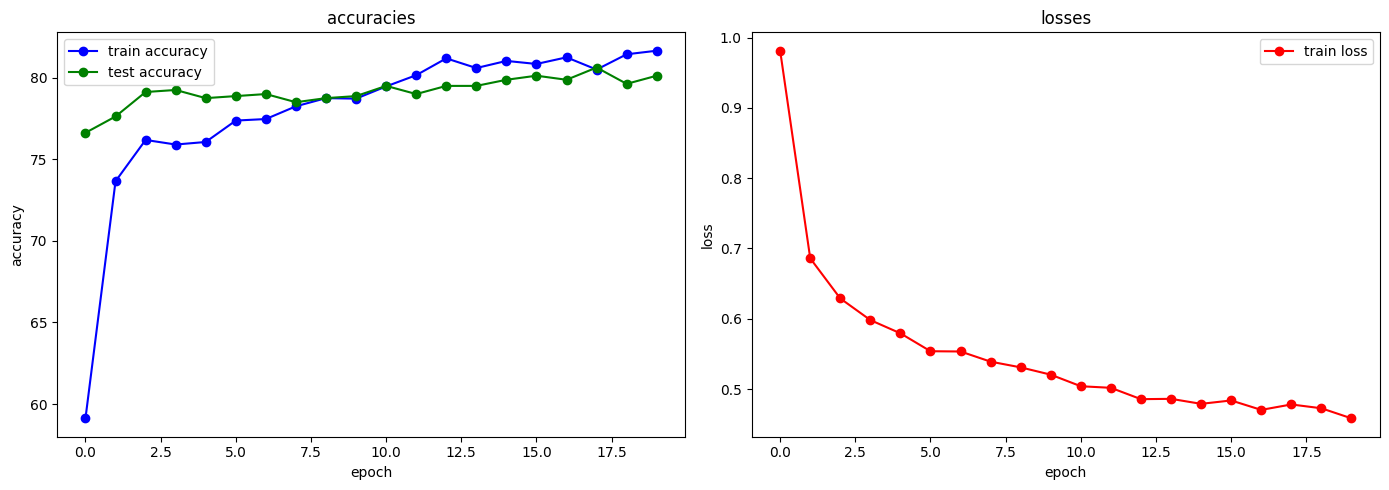

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(train_accuracies_list, label='train accuracy', marker='o', color='b')
axs[0].plot(test_accuracies_list, label='test accuracy', marker='o', color='g')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('accuracies')
axs[0].legend()

axs[1].plot(train_losses_list, label='train loss', marker='o', color='r')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('losses')
axs[1].legend()

plt.tight_layout()
plt.show()

<p class="task" id="4"></p>

### 4
Повторите решение предыдущей задачи, заморозив все сверточные слои, кроме последнего (слои классификатора не замораживайте). Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей.

- [ ] Проверено на семинаре

In [ ]:
model = vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

model.classifier[6] = nn.Linear(in_features=4096, out_features=4)

for param in model.features:
    param.requires_grad_(False)

model.features[-3].requires_grad_(True)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
parameters_counter = 0

for param in model.parameters():
    if param.requires_grad:
        parameters_counter += param.numel()
print(f"Количество настраиваемых параметров {parameters_counter}")

Количество настраиваемых параметров 121922052


In [ ]:
model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

train_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

epochs = 20

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        correct_train += (predicted == labels).sum().item()
        total_train += len(labels)

    train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses_list.append(train_loss)
    train_accuracies_list.append(train_accuracy)

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            correct_test += (predicted == labels).sum().item()
            total_test += len(labels)

    test_accuracy = correct_test / total_test * 100
    test_accuracies_list.append(test_accuracy)

    print(f"Epoch {epoch+1}, Loss: {round(train_loss, 5)}, Train Accuracy: {round(train_accuracy, 3)}%, Test Accuracy: {round(test_accuracy, 3)}%")

print(f"Final Train accuracy = {train_accuracies_list[-1]}")
print(f"Final Test accuracy = {test_accuracies_list[-1]}")

  5%|▌         | 1/20 [00:44<14:08, 44.66s/it]

Epoch 1, Loss: 0.63114, Train Accuracy: 73.156%, Test Accuracy: 81.75%


 10%|█         | 2/20 [01:26<12:59, 43.29s/it]

Epoch 2, Loss: 0.30003, Train Accuracy: 88.25%, Test Accuracy: 82.5%


 15%|█▌        | 3/20 [02:08<12:05, 42.67s/it]

Epoch 3, Loss: 0.12, Train Accuracy: 95.562%, Test Accuracy: 79.25%


 20%|██        | 4/20 [02:51<11:19, 42.48s/it]

Epoch 4, Loss: 0.03259, Train Accuracy: 98.844%, Test Accuracy: 80.625%


 25%|██▌       | 5/20 [03:33<10:36, 42.41s/it]

Epoch 5, Loss: 0.0153, Train Accuracy: 99.594%, Test Accuracy: 80.625%


 30%|███       | 6/20 [04:15<09:53, 42.40s/it]

Epoch 6, Loss: 0.02249, Train Accuracy: 99.188%, Test Accuracy: 79.125%


 35%|███▌      | 7/20 [04:57<09:07, 42.15s/it]

Epoch 7, Loss: 0.00822, Train Accuracy: 99.781%, Test Accuracy: 81.125%


 40%|████      | 8/20 [05:39<08:24, 42.00s/it]

Epoch 8, Loss: 0.00717, Train Accuracy: 99.75%, Test Accuracy: 80.0%


 45%|████▌     | 9/20 [06:21<07:42, 42.00s/it]

Epoch 9, Loss: 0.01501, Train Accuracy: 99.562%, Test Accuracy: 81.125%


 50%|█████     | 10/20 [07:02<06:59, 41.97s/it]

Epoch 10, Loss: 0.00909, Train Accuracy: 99.812%, Test Accuracy: 80.5%


 55%|█████▌    | 11/20 [07:44<06:16, 41.89s/it]

Epoch 11, Loss: 0.00118, Train Accuracy: 100.0%, Test Accuracy: 80.25%


 60%|██████    | 12/20 [08:26<05:34, 41.85s/it]

Epoch 12, Loss: 0.00065, Train Accuracy: 100.0%, Test Accuracy: 81.5%


 65%|██████▌   | 13/20 [09:08<04:53, 41.88s/it]

Epoch 13, Loss: 0.0002, Train Accuracy: 100.0%, Test Accuracy: 81.0%


 70%|███████   | 14/20 [09:50<04:12, 42.09s/it]

Epoch 14, Loss: 0.00013, Train Accuracy: 100.0%, Test Accuracy: 81.375%


 75%|███████▌  | 15/20 [10:33<03:31, 42.36s/it]

Epoch 15, Loss: 0.00214, Train Accuracy: 99.969%, Test Accuracy: 81.375%


 80%|████████  | 16/20 [11:16<02:49, 42.35s/it]

Epoch 16, Loss: 0.00037, Train Accuracy: 100.0%, Test Accuracy: 79.875%


 85%|████████▌ | 17/20 [11:59<02:07, 42.64s/it]

Epoch 17, Loss: 0.00053, Train Accuracy: 100.0%, Test Accuracy: 79.75%


 90%|█████████ | 18/20 [12:42<01:25, 42.59s/it]

Epoch 18, Loss: 0.00019, Train Accuracy: 100.0%, Test Accuracy: 82.25%


 95%|█████████▌| 19/20 [13:23<00:42, 42.37s/it]

Epoch 19, Loss: 0.00023, Train Accuracy: 100.0%, Test Accuracy: 76.75%


100%|██████████| 20/20 [14:05<00:00, 42.29s/it]

Epoch 20, Loss: 0.03442, Train Accuracy: 99.031%, Test Accuracy: 77.625%
Final Train accuracy = 99.03125
Final Test accuracy = 77.625


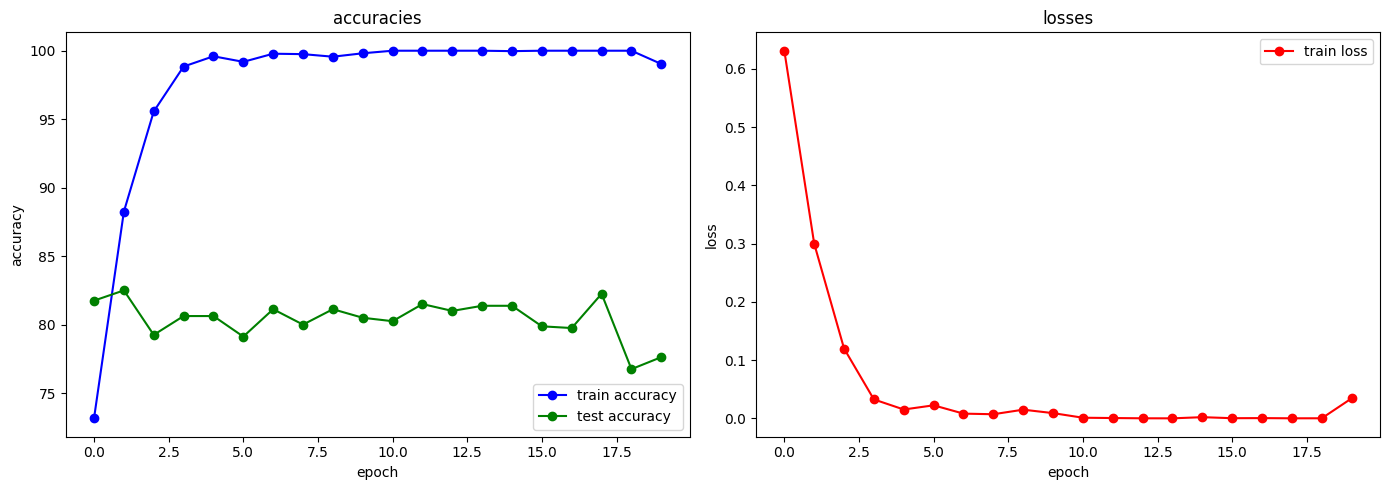

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(train_accuracies_list, label='train accuracy', marker='o', color='b')
axs[0].plot(test_accuracies_list, label='test accuracy', marker='o', color='g')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('accuracies')
axs[0].legend()

axs[1].plot(train_losses_list, label='train loss', marker='o', color='r')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('losses')
axs[1].legend()

plt.tight_layout()
plt.show()

**Выросло количество настраиваемых параметров \
Время обучения увеличилось, но не существенно \
Точность предсказаний модели увеличилась**

<p class="task" id="5"></p>

### 5
Повторите решение задачи, расширив обучающий набор данных при помощи преобразований из `torchvision`, изменяющих изображение (повороты, изменение интенсивности пикселей, обрезание и т.д.). При оценке модели на тестовой выборке данные преобразования применяться не должны. Решение о том, сколько и каких слоев модели будет обучаться, примите самостоятельно.

- [ ] Проверено на семинаре

In [ ]:
cat_dataset = ImageFolder(root='/kaggle/input/cat-breeds/cat_breeds_4')

train_dataset, test_dataset = random_split(cat_dataset, [0.8, 0.2])

train_dataset.dataset = copy(train_dataset.dataset)

transform = T.Compose([
    T.RandomHorizontalFlip(0.5),  # Случайный горизонтальный переворот с вероятностью 0.5
    T.RandomRotation(degrees=30),  # Случайное вращение изображения на угол до 30 градусов
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Случайные изменения яркости и контрастности
    T.ToTensor(),
    T.Resize(size=(256, 256)),
    T.CenterCrop(size=(224, 224)),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset.dataset.transform = transform
test_dataset.dataset.transform = models.VGG16_Weights.IMAGENET1K_V1.transforms()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

model.classifier[6] = nn.Linear(in_features=4096, out_features=4)

for param in model.features:
    param.requires_grad_(False)

model.features[-3].requires_grad_(True)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

train_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

epochs = 20

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        correct_train += (predicted == labels).sum().item()
        total_train += len(labels)

    train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses_list.append(train_loss)
    train_accuracies_list.append(train_accuracy)

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            correct_test += (predicted == labels).sum().item()
            total_test += len(labels)

    test_accuracy = correct_test / total_test * 100
    test_accuracies_list.append(test_accuracy)

    print(f"Epoch {epoch+1}, Loss: {round(train_loss, 5)}, Train Accuracy: {round(train_accuracy, 3)}%, Test Accuracy: {round(test_accuracy, 3)}%")

print(f"Final Train accuracy = {train_accuracies_list[-1]}")
print(f"Final Test accuracy = {test_accuracies_list[-1]}")

  5%|▌         | 1/20 [00:51<16:17, 51.45s/it]

Epoch 1, Loss: 0.66489, Train Accuracy: 72.406%, Test Accuracy: 81.125%


 10%|█         | 2/20 [01:42<15:23, 51.29s/it]

Epoch 2, Loss: 0.47062, Train Accuracy: 80.156%, Test Accuracy: 79.875%


 15%|█▌        | 3/20 [02:33<14:28, 51.10s/it]

Epoch 3, Loss: 0.39154, Train Accuracy: 84.375%, Test Accuracy: 81.25%


 20%|██        | 4/20 [03:25<13:43, 51.45s/it]

Epoch 4, Loss: 0.32997, Train Accuracy: 86.969%, Test Accuracy: 79.875%


 25%|██▌       | 5/20 [04:16<12:49, 51.33s/it]

Epoch 5, Loss: 0.29625, Train Accuracy: 88.844%, Test Accuracy: 81.25%


 30%|███       | 6/20 [05:08<11:59, 51.40s/it]

Epoch 6, Loss: 0.23681, Train Accuracy: 91.656%, Test Accuracy: 80.625%


 35%|███▌      | 7/20 [05:59<11:06, 51.29s/it]

Epoch 7, Loss: 0.20782, Train Accuracy: 92.281%, Test Accuracy: 78.875%


 40%|████      | 8/20 [06:50<10:17, 51.43s/it]

Epoch 8, Loss: 0.15889, Train Accuracy: 94.375%, Test Accuracy: 79.875%


 45%|████▌     | 9/20 [07:43<09:28, 51.71s/it]

Epoch 9, Loss: 0.13268, Train Accuracy: 94.75%, Test Accuracy: 79.625%


 50%|█████     | 10/20 [08:35<08:38, 51.84s/it]

Epoch 10, Loss: 0.11566, Train Accuracy: 95.688%, Test Accuracy: 79.5%


 55%|█████▌    | 11/20 [09:25<07:42, 51.36s/it]

Epoch 11, Loss: 0.11071, Train Accuracy: 96.0%, Test Accuracy: 79.625%


 60%|██████    | 12/20 [10:16<06:49, 51.23s/it]

Epoch 12, Loss: 0.07497, Train Accuracy: 97.531%, Test Accuracy: 79.875%


 65%|██████▌   | 13/20 [11:08<05:59, 51.29s/it]

Epoch 13, Loss: 0.07311, Train Accuracy: 97.406%, Test Accuracy: 78.75%


 70%|███████   | 14/20 [11:58<05:06, 51.15s/it]

Epoch 14, Loss: 0.05972, Train Accuracy: 98.125%, Test Accuracy: 80.5%


 75%|███████▌  | 15/20 [12:50<04:16, 51.27s/it]

Epoch 15, Loss: 0.06138, Train Accuracy: 97.812%, Test Accuracy: 80.25%


 80%|████████  | 16/20 [13:41<03:25, 51.30s/it]

Epoch 16, Loss: 0.06335, Train Accuracy: 97.594%, Test Accuracy: 80.75%


 85%|████████▌ | 17/20 [14:32<02:33, 51.16s/it]

Epoch 17, Loss: 0.04315, Train Accuracy: 98.312%, Test Accuracy: 79.375%


 90%|█████████ | 18/20 [15:23<01:42, 51.18s/it]

Epoch 18, Loss: 0.05027, Train Accuracy: 98.094%, Test Accuracy: 82.625%


 95%|█████████▌| 19/20 [16:14<00:51, 51.14s/it]

Epoch 19, Loss: 0.05285, Train Accuracy: 98.219%, Test Accuracy: 80.0%


100%|██████████| 20/20 [17:07<00:00, 51.36s/it]

Epoch 20, Loss: 0.04493, Train Accuracy: 98.688%, Test Accuracy: 80.375%
Final Train accuracy = 98.6875
Final Test accuracy = 80.375


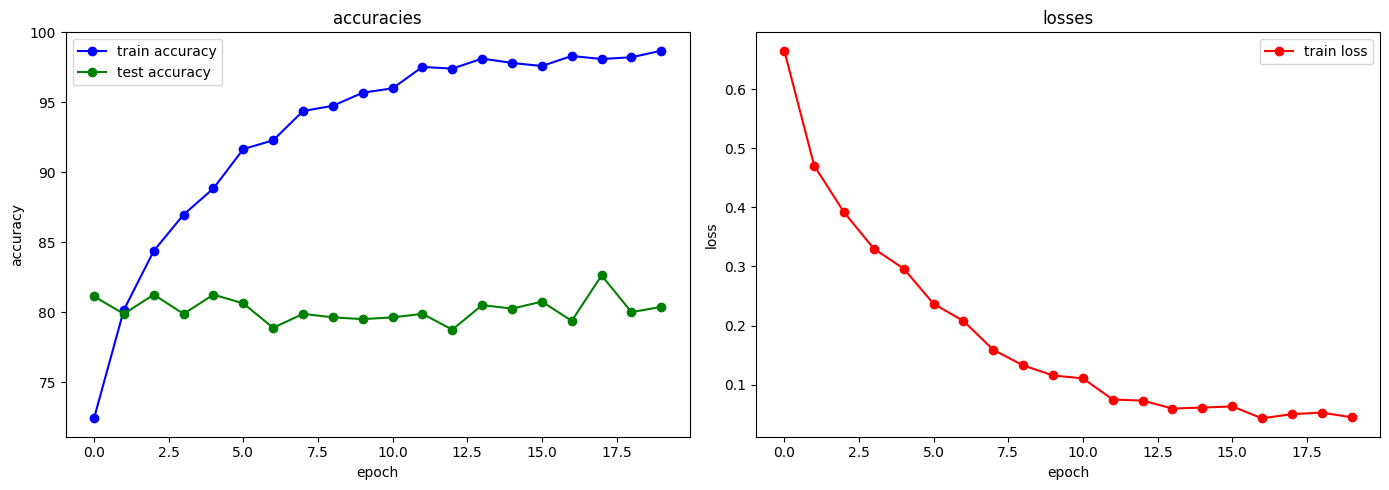

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(train_accuracies_list, label='train accuracy', marker='o', color='b')
axs[0].plot(test_accuracies_list, label='test accuracy', marker='o', color='g')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('accuracies')
axs[0].legend()

axs[1].plot(train_losses_list, label='train loss', marker='o', color='r')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('losses')
axs[1].legend()

plt.tight_layout()
plt.show()

**Точность на тестовой выборке увеличилась**

## Обратная связь
- [x] Хочу получить обратную связь по решению